# Benchmarking Hyperoptax

In [1]:
import time

from bayes_opt import BayesianOptimization
import jax.numpy as jnp
import jax
import bayex
import matplotlib.pyplot as plt

from hyperoptax.bayesian import BayesianOptimizer
from hyperoptax.spaces import LinearSpace

# Comparing to other Bayesian Optimization libraries

In [2]:
# Bounded region of parameter space
bo_bounds = {"x": (2, 4), "y": (0, 2)}
bayex_bounds = {"x": bayex.domain.Real(2.0, 4.0), "y": bayex.domain.Real(0.0, 2.0)}
hoptax_bounds = {"x": LinearSpace(2.0, 4.0, 100), "y": LinearSpace(0.0, 2.0, 100)}


def f(x, y):
    return -(1.4 - 3 * x) * jnp.sin(18 * y)


# Bayesian-Optimization
bo_optimizer = BayesianOptimization(
    f=f,
    pbounds=bo_bounds,
    random_state=1,
)

# bayex
bayex_optimizer = bayex.Optimizer(domain=bayex_bounds, maximize=True, acq="PI")

# hyperoptax
hoptax_optimizer = BayesianOptimizer(hoptax_bounds, f=f)

### Bayesian-optimization

In [3]:
start = time.time()
bo_optimizer.maximize(
    init_points=3,
    n_iter=100,
)

bo_time = time.time() - start
bo_max = bo_optimizer.max["target"]
print(f"Time taken: {bo_time:.2f} seconds")
print("Best value: ", bo_max)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | 5.0895161 | 2.8340440 | 1.4406489 |
| 2         | -4.572064 | 2.0002287 | 0.6046651 |
| 3         | -0.995176 | 2.2935117 | 0.1846771 |
| 4         | -5.414693 | 3.1038088 | 1.7034514 |
| 5         | 6.2081246 | 3.1140982 | 1.4461141 |
| 6         | 4.2967567 | 2.6356989 | 0.4835297 |
| 7         | 2.4481501 | 2.2680780 | 1.7714478 |
| 8         | -4.903664 | 2.1455481 | 0.6236598 |
| 9         | -4.865993 | 2.6553993 | 1.6989593 |
| 10        | -5.888856 | 2.9050529 | 0.9952135 |
| 11        | 2.1080741 | 2.9865215 | 1.4119638 |
| 12        | 5.5928030 | 3.0482069 | 1.1769021 |
| 13        | -4.827859 | 3.9719134 | 0.5500982 |
| 14        | 3.4555957 | 2.0855980 | 1.4402426 |
| 15        | -7.947717 | 3.1186634 | 1.3115306 |
| 16        | -1.756889 | 2.1420128 | 1.3764246 |
| 17        | 1.9615039 | 2.2338609 | 0.7191868 |
| 18        | 7.3689827 | 2.9458789 | 0.7929524 |


### Bayex

In [4]:
start = time.time()
# Define some prior evaluations to initialise the GP.
params = {"x": [0.0, 0.5, 1.0], "y": [0.0, 0.0, 0.0]}
ys = [f(x, y) for x, y in zip(params["x"], params["y"])]
opt_state = bayex_optimizer.init(ys, params)

# Sample new points using Jax PRNG approach.
ori_key = jax.random.key(42)
for step in range(97): 
    key = jax.random.fold_in(ori_key, step)
    new_params = bayex_optimizer.sample(key, opt_state)
    y_new = f(**new_params)
    opt_state = bayex_optimizer.fit(opt_state, y_new, new_params)

bayex_time = time.time() - start
bayex_max = opt_state.best_score
print(f"Time taken: {bayex_time:.2f} seconds")
print("Best value: ", bayex_max)

Time taken: 5.39 seconds
Best value:  10.569071


### Hyperoptax

In [10]:
start = time.time()
result = hoptax_optimizer.optimize(n_iterations=100, n_parallel=5, jit=True)

hoptax_time = time.time() - start
hoptax_max = hoptax_optimizer.max["target"]
print(f"Time taken: {hoptax_time:.2f} seconds")
print("Best value: ", hoptax_max)

Running for 20 iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Time taken: 0.27 seconds
Best value:  10.589436


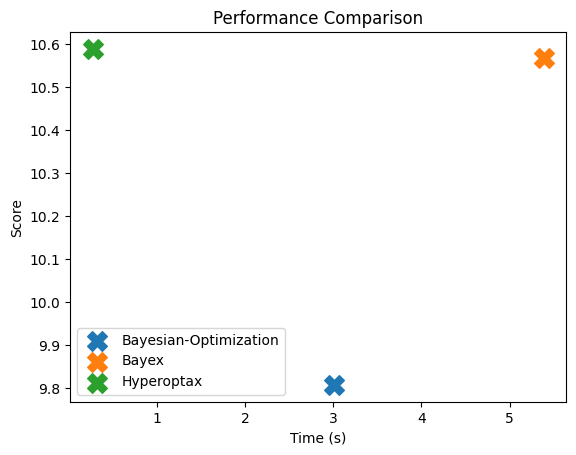

In [11]:
# plot the results
times = (bo_time, bayex_time, hoptax_time)
scores = (bo_max, bayex_max, hoptax_max)

for _time, _score in zip(times, scores):
    plt.scatter(_time, _score,200, marker="X", )

plt.xlabel("Time (s)")
plt.ylabel("Score")
plt.title("Performance Comparison")
plt.legend(["Bayesian-Optimization", "Bayex", "Hyperoptax"])
plt.show()

# What's better iterations or parallisations?